# Подготовка модели распознавания рукописных букв и цифр

In [6]:
from torchvision.datasets import EMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

### Загрузка и визуализация данных

In [2]:
# Преобразования изображений: конвертация в тензор и нормализация
transform = Compose([ToTensor(), Normalize([0.5], [0.5])])

# Загрузка набора данных EMNIST
dataset = EMNIST('data/', 'balanced', download=False, transform=transform)

In [5]:
# Загружаем соответствия между лейблами и символами
def load_mapping(mapping_path):
    label_to_char = {}
    with open(mapping_path, 'r') as f:
        for line in f:
            label, char = line.strip().split()
            label_to_char[int(label)] = chr(int(char))
    return label_to_char

mapping_path = 'emnist-balanced-mapping.txt'
label_to_char = load_mapping(mapping_path)

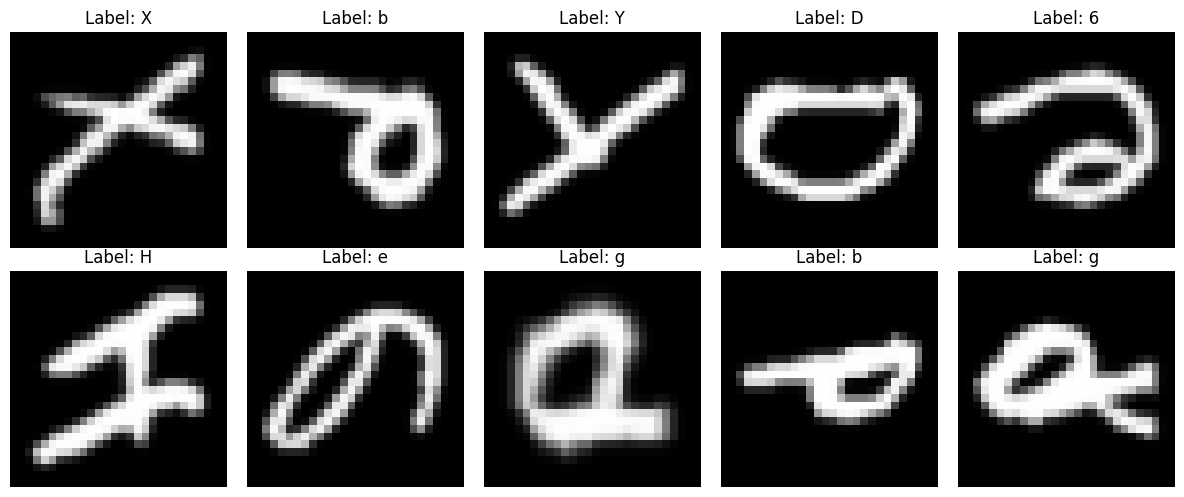

In [8]:
# Преобразования для отображения
def denormalize(tensor, mean, std):
    """Возвращает изображение в исходном формате (до нормализации)."""
    mean = np.array(mean).reshape(1, 1, 1)
    std = np.array(std).reshape(1, 1, 1)
    tensor = tensor * std + mean
    return tensor

def show_images(dataset, label_to_char, num_images=5):
    """Отображает несколько изображений из набора данных с соответствующими метками."""
    data_loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(data_loader))
    
    # Сопоставление меток с символами
    labels = labels.numpy()
    images = images.numpy()

    # Параметры для отображения
    num_cols = min(num_images, 5)
    num_rows = (num_images + num_cols - 1) // num_cols
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 5))
    axes = axes.flatten()

    for i in range(num_images):
        image = denormalize(images[i], [0.5], [0.5]).squeeze() 
        label = label_to_char.get(labels[i], 'Unknown')

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

mapping_path = 'emnist-balanced-mapping.txt'
label_to_char = load_mapping(mapping_path)

show_images(dataset, label_to_char, num_images=10)

### Подготовка данных для обучения и валидации

In [9]:
# Разделение данных на обучающую и валидационную выборки
train_dataset = EMNIST('data/', 'balanced', train=True, download=False, transform=transform)
val_dataset = EMNIST('data/', 'balanced', train=False, download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512)

### Определение модели

In [10]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(0.25),

            nn.Flatten(),
            nn.Linear(in_features=64 * 7 * 7, out_features=128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=128, out_features=n_classes)
        )

    def forward(self, x):
        return self.model(x)
    
model = CNN(47) 

### Определение функций обучения и валидации

In [15]:
# Функция обучения
def train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre):
    best_acc = 0
    patience = 3 
    wait = 0

    for epoch in range(n_epoch):
        model.train()
        loss_sum = 0
        print(f'Epoch: {epoch+1}/{n_epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data)
            loss = loss_f(output, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean Train Loss: {loss_sum / (step + 1):.6f}\n')

        # Валидация и ранняя остановка
        if epoch % val_fre == 0:
            val_acc = validate(model, val_loader)
            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model.state_dict(), 'model.ckpt')
                wait = 0
            else:
                wait += 1
                if wait >= patience:
                    print(f'Ранняя остановка на {epoch+1} эпохе')
                    break

def validate(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    with torch.no_grad():
        for step, (data, target) in enumerate(val_loader):
            output = model(data)
            loss = loss_f(output, target)
            loss_sum += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)
    print(f'Val Loss: {loss_sum / (step + 1):.6f} \tAccuracy: {acc:.2f}')
    return acc

In [16]:
# Оптимизатор и функция потерь
loss_f = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Параметры обучения
n_epoch = 20
val_fre = 1

# Обучение модели
train(model, optimizer, loss_f, train_loader, val_loader, n_epoch, val_fre)


Epoch: 1/20
Iter: 0 	Loss: 0.5555078387260437
Iter: 10 	Loss: 0.5319530963897705
Iter: 20 	Loss: 0.6529417037963867
Iter: 30 	Loss: 0.5579660534858704
Iter: 40 	Loss: 0.7035213708877563
Iter: 50 	Loss: 0.6420392394065857
Iter: 60 	Loss: 0.5872600078582764
Iter: 70 	Loss: 0.5974962115287781
Iter: 80 	Loss: 0.5766079425811768
Iter: 90 	Loss: 0.5564576983451843
Iter: 100 	Loss: 0.5749028325080872
Iter: 110 	Loss: 0.5368410348892212
Iter: 120 	Loss: 0.5570236444473267
Iter: 130 	Loss: 0.5990203619003296
Iter: 140 	Loss: 0.5566893815994263
Iter: 150 	Loss: 0.6034066081047058
Iter: 160 	Loss: 0.5918940901756287
Iter: 170 	Loss: 0.5676255822181702
Iter: 180 	Loss: 0.44827336072921753
Iter: 190 	Loss: 0.4952164888381958
Iter: 200 	Loss: 0.5222618579864502
Iter: 210 	Loss: 0.5601749420166016
Iter: 220 	Loss: 0.46244102716445923
Mean Train Loss: 0.582258

Val Loss: 0.399373 	Accuracy: 0.86
Epoch: 2/20
Iter: 0 	Loss: 0.4946211278438568
Iter: 10 	Loss: 0.4662303626537323
Iter: 20 	Loss: 0.54316747

In [17]:
torch.save(model.state_dict(), 'model.ckpt')

In [18]:
# Загрузка лучшей сохранённой модели
model.load_state_dict(torch.load('model.ckpt'))

# Проверка на валидационном наборе данных
print("\nРезультаты лучшей модели:")
validate(model, val_loader)

C:\Users\natas\AppData\Local\Temp\ipykernel_19432\762711838.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.ckpt'))



Результаты лучшей модели:
Val Loss: 0.333939 	Accuracy: 0.88


0.8817021276595745